In [1]:
import requests
import pandas as pd

query = """
[out:json][timeout:25];
area["name"="Bengaluru"]->.searchArea;
(
  node["amenity"="police"](area.searchArea);
  way["amenity"="police"](area.searchArea);
  relation["amenity"="police"](area.searchArea);

  node["amenity"="fire_station"](area.searchArea);
  way["amenity"="fire_station"](area.searchArea);
  relation["amenity"="fire_station"](area.searchArea);

  node["amenity"="hospital"](area.searchArea);
  way["amenity"="hospital"](area.searchArea);
  relation["amenity"="hospital"](area.searchArea);
);
out center;
"""

url = "https://overpass-api.de/api/interpreter"

response = requests.get(url, params={'data': query})

if response.status_code == 200:
    data = response.json()
else:
    print("Error fetching data:", response.status_code)
    data = None

if data:
    records = []
    for element in data['elements']:
        # Extract relevant fields
        element_id = element.get('id')
        amenity_type = element.get('tags', {}).get('amenity', 'Unknown')
        name = element.get('tags', {}).get('name', 'Unnamed')
        latitude = element.get('lat')
        longitude = element.get('lon')
        
        records.append({
            'ID': element_id,
            'Amenity Type': amenity_type,
            'Name': name,
            'Latitude': latitude,
            'Longitude': longitude
        })

    df = pd.DataFrame(records)
    df.to_excel(r"D:\All college notes\5th Semester\2. Design and Analysis of Algorithms\Project\bangalore_amenities.xlsx", index=False)

    print("Data successfully saved to bangalore_amenities.xlsx")
else:
    print("No data to save.")


Data successfully saved to bangalore_amenities.xlsx


In [1]:
import pandas as pd
import math

class Point:
    def __init__(self, x, y, data=None):
        self.x = x
        self.y = y
        self.data = data 

    def __repr__(self):
        return f"Point({self.x}, {self.y}, {self.data})"


class Rectangle:
    def __init__(self, x, y, w, h):
        self.x = x  
        self.y = y 
        self.w = w 
        self.h = h

    def contains(self, point):
        return (self.x - self.w <= point.x <= self.x + self.w and
                self.y - self.h <= point.y <= self.y + self.h)

    def intersects(self, range):
        return not (range.x - range.w > self.x + self.w or
                    range.x + range.w < self.x - self.w or
                    range.y - range.h > self.y + self.h or
                    range.y + range.h < self.y - self.h)


class Quadtree:
    def __init__(self, boundary, capacity):
        self.boundary = boundary
        self.capacity = capacity
        self.points = []
        self.divided = False

    def subdivide(self):
        x, y, w, h = self.boundary.x, self.boundary.y, self.boundary.w, self.boundary.h
        self.northeast = Quadtree(Rectangle(x + w / 2, y - h / 2, w / 2, h / 2), self.capacity)
        self.northwest = Quadtree(Rectangle(x - w / 2, y - h / 2, w / 2, h / 2), self.capacity)
        self.southeast = Quadtree(Rectangle(x + w / 2, y + h / 2, w / 2, h / 2), self.capacity)
        self.southwest = Quadtree(Rectangle(x - w / 2, y + h / 2, w / 2, h / 2), self.capacity)
        self.divided = True

    def insert(self, point):
        if not self.boundary.contains(point):
            return False

        if len(self.points) < self.capacity:
            self.points.append(point)
            return True
        else:
            if not self.divided:
                self.subdivide()

            if self.northeast.insert(point):
                return True
            elif self.northwest.insert(point):
                return True
            elif self.southeast.insert(point):
                return True
            elif self.southwest.insert(point):
                return True
        return False

    def query(self, range, found):
        if not self.boundary.intersects(range):
            return

        for point in self.points:
            if range.contains(point):
                found.append(point)

        if self.divided:
            self.northeast.query(range, found)
            self.northwest.query(range, found)
            self.southeast.query(range, found)
            self.southwest.query(range, found)


def calculate_distance(lat1, lon1, lat2, lon2):
    return math.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)


def find_nearest_responses_by_type(quadtree, target_lat, target_lon, type_mapping, initial_radius=0.01, max_radius=500):
    search_radius = initial_radius
    nearest_points = {label: None for label in type_mapping.values()}
    min_distances = {label: float('inf') for label in type_mapping.values()}

    while search_radius <= max_radius:
        search_area = Rectangle(target_lon, target_lat, search_radius, search_radius)
        found_points = []

        quadtree.query(search_area, found_points)

        for point in found_points:
            amenity_type = point.data['Type'].strip().lower()
            location_type = type_mapping.get(amenity_type)

            if location_type:
                distance = calculate_distance(target_lat, target_lon, point.y, point.x)
                if distance < min_distances[location_type]:
                    min_distances[location_type] = distance
                    nearest_points[location_type] = point

        if all(nearest_points.values()):
            break
        search_radius *= 2

    return nearest_points, min_distances


In [4]:

df = pd.read_excel(r"D:\All college notes\5th Semester\2. Design and Analysis of Algorithms\Project\bangalore_amenities.xlsx")

boundary = Rectangle(77.5946, 12.9716, 0.1, 0.1)
quadtree = Quadtree(boundary, 4) 

for _, row in df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    amenity_type = row['Amenity Type']
    name = row['Name']
    unique_id = row['ID']
    
    point = Point(longitude, latitude, {
        'Type': amenity_type,
        'Name': name,
        'ID': unique_id
    })
    
    quadtree.insert(point)

print("Data from Excel has been inserted into the quadtree.")

Data from Excel has been inserted into the quadtree.


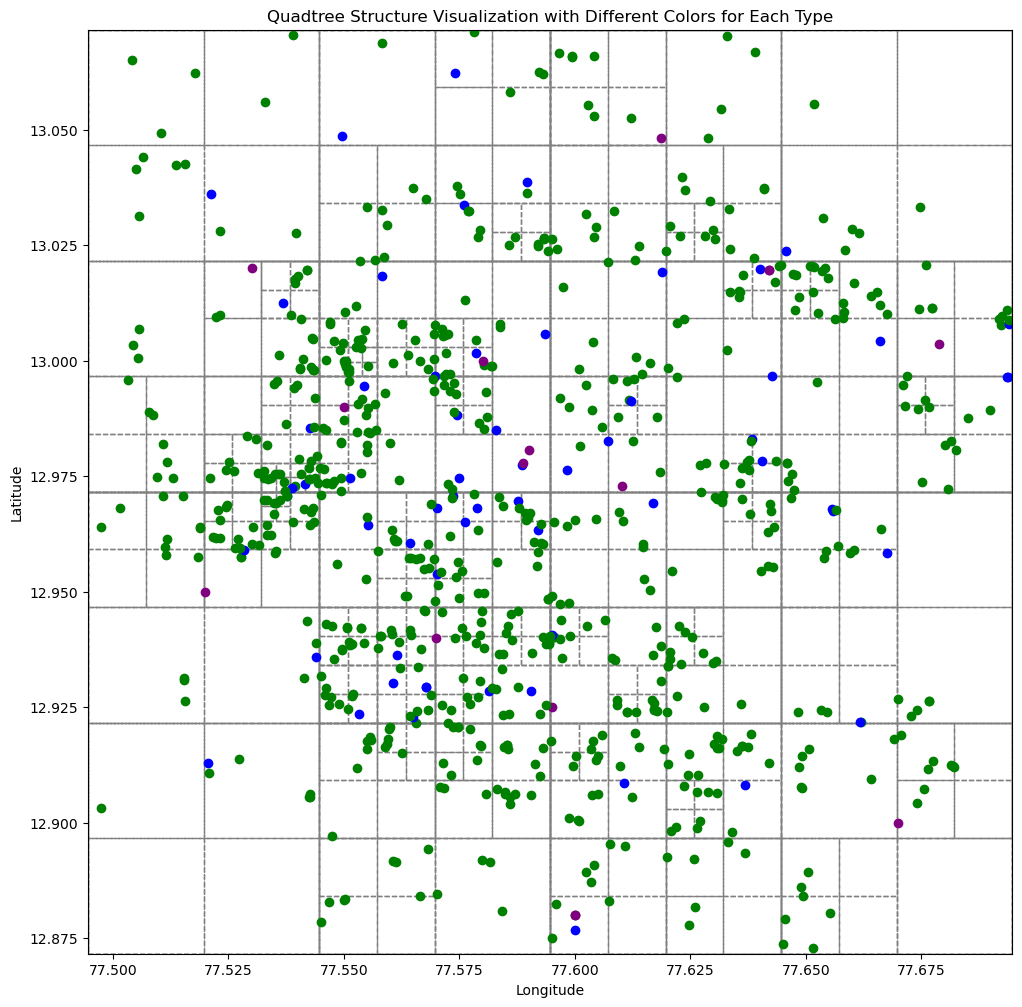

In [5]:
import matplotlib.pyplot as plt

def plot_quadtree_with_types(ax, quadtree):
    boundary = quadtree.boundary
    rect = plt.Rectangle((boundary.x - boundary.w, boundary.y - boundary.h),
                         boundary.w * 2, boundary.h * 2, fill=False, edgecolor='gray', linestyle='--')
    ax.add_patch(rect)

    for point in quadtree.points:
        color = {
            "police": "blue",
            "hospital": "green",
            "fire_station": "purple"
        }.get(point.data['Type'], "black") 
        ax.plot(point.x, point.y, 'o', color=color, markersize=6)

    if quadtree.divided:
        plot_quadtree_with_types(ax, quadtree.northeast)
        plot_quadtree_with_types(ax, quadtree.northwest)
        plot_quadtree_with_types(ax, quadtree.southeast)
        plot_quadtree_with_types(ax, quadtree.southwest)

fig, ax = plt.subplots(figsize=(12, 12))
ax.set_aspect('equal', 'box')
plot_quadtree_with_types(ax, quadtree)
ax.set_xlim(boundary.x - boundary.w, boundary.x + boundary.w)
ax.set_ylim(boundary.y - boundary.h, boundary.y + boundary.h)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Quadtree Structure Visualization with Different Colors for Each Type")
plt.show()


In [6]:
target_latitude = 12.95
target_longitude = 77.6185279

type_mapping = {
    'hospital': 'Hospital',
    'police': 'Police Station',
    'fire_station': 'Fire Station'
}

nearest_responses, min_distances = find_nearest_responses_by_type(quadtree, target_latitude, target_longitude, type_mapping)

print("Nearest Emergency Response Locations:")
for location_type, nearest_point in nearest_responses.items():
    if nearest_point:
        print(f"{location_type}: {nearest_point.data['Name']} at ({nearest_point.y}, {nearest_point.x})")
    else:
        print(f"{location_type}: No location found within the search radius.")


Nearest Emergency Response Locations:
Hospital: Government Primary Health Centre at (12.9503234, 77.6162619)
Police Station: Karnataka State Reserve Police at (12.9691307, 77.6168652)
Fire Station: Office of the Chief Fire Officer at (12.97283, 77.61024)


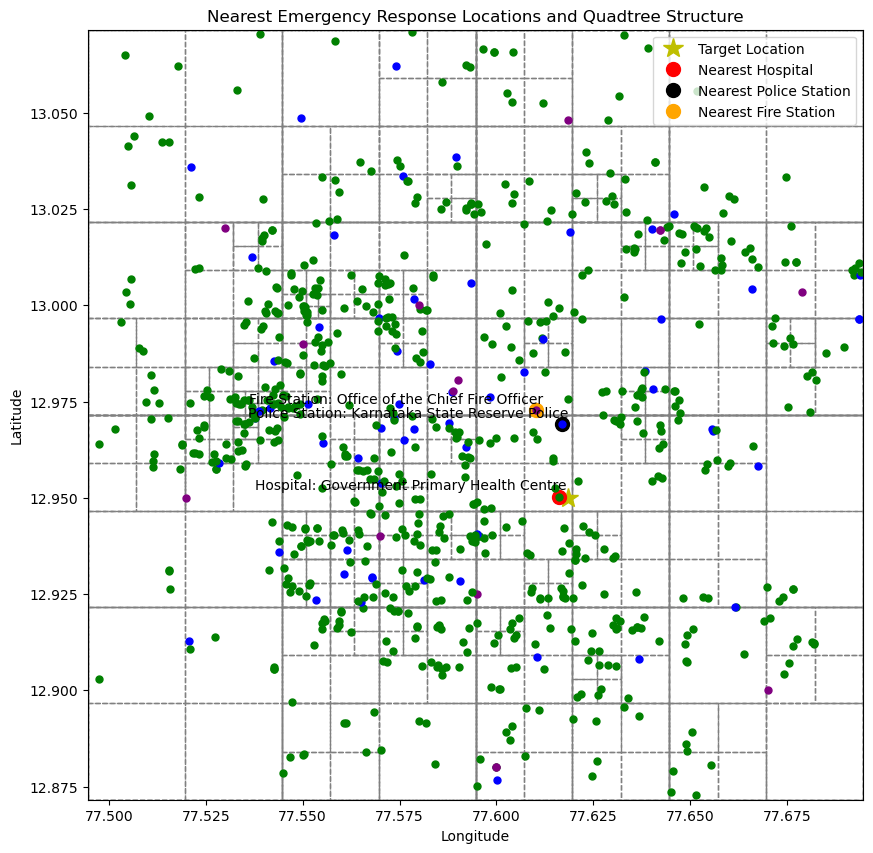

In [7]:
def plot_nearest_responses(quadtree, target_lat, target_lon, nearest_points):
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.plot(target_lon, target_lat, 'y*', markersize=15, label='Target Location')

    for location_type, nearest_point in nearest_points.items():
        if nearest_point:
            color = {'Police Station': 'black', 'Hospital': 'red', 'Fire Station': 'orange'}.get(location_type, 'black')
            ax.plot(nearest_point.x, nearest_point.y, 'o', color=color, markersize=10, label=f"Nearest {location_type}")
            ax.annotate(f"{location_type}: {nearest_point.data['Name']}",
                        (nearest_point.x, nearest_point.y),
                        textcoords="offset points",
                        xytext=(5, 5),
                        ha='right')

    def plot_quadtree(ax, quadtree):
        boundary = quadtree.boundary
        rect = plt.Rectangle((boundary.x - boundary.w, boundary.y - boundary.h),
                             boundary.w * 2, boundary.h * 2, fill=False, edgecolor='gray', linestyle='--')
        ax.add_patch(rect)

        for point in quadtree.points:
            color = {
            "police": "blue",
            "hospital": "green",
            "fire_station": "purple"
        }.get(point.data['Type'], 'black')
            ax.plot(point.x, point.y, 'o', color=color, markersize=5)

        if quadtree.divided:
            plot_quadtree(ax, quadtree.northeast)
            plot_quadtree(ax, quadtree.northwest)
            plot_quadtree(ax, quadtree.southeast)
            plot_quadtree(ax, quadtree.southwest)

    plot_quadtree(ax, quadtree)

    ax.set_xlim(quadtree.boundary.x - quadtree.boundary.w, quadtree.boundary.x + quadtree.boundary.w)
    ax.set_ylim(quadtree.boundary.y - quadtree.boundary.h, quadtree.boundary.y + quadtree.boundary.h)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Nearest Emergency Response Locations and Quadtree Structure")
    plt.legend(loc='upper right')
    plt.show()

plot_nearest_responses(quadtree, target_latitude, target_longitude, nearest_responses)


In [10]:
import tkinter as tk
from tkinter import ttk, messagebox
from tkintermapview import TkinterMapView
import math

file_path = r"D:\All college notes\5th Semester\2. Design and Analysis of Algorithms\Project\bangalore_amenities.xlsx"
data = pd.read_excel(file_path)

type_column = "Amenity Type"
name_column = "Name"
latitude_column = "Latitude"
longitude_column = "Longitude"

type_mapping = {
    'hospital': 'Hospital',
    'police': 'Police Station',
    'fire_station': 'Fire Station'
}

boundary = Rectangle(77.5946, 12.9716, 0.1, 0.1)
quadtree = Quadtree(boundary, capacity=4)

for _, row in data.iterrows():
    point = Point(row[longitude_column], row[latitude_column], {
        "Type": row[type_column],
        "Name": row[name_column]
    })
    quadtree.insert(point)


def search_nearest():
    try:
        lat = float(lat_entry.get())
        lon = float(lon_entry.get())
        nearest_responses, min_distances = find_nearest_responses_by_type(quadtree, lat, lon, type_mapping)
        result_text.delete(1.0, tk.END)
        map_widget.delete_all_marker()

        map_widget.set_marker(lat, lon, text="Target Location (Highlighted)")

        for location_type, nearest_point in nearest_responses.items():
            if nearest_point:
                distance = min_distances[location_type]
                result_text.insert(tk.END, f"{location_type}: {nearest_point.data['Name']} at Latitude: {nearest_point.y}, Longitude: {nearest_point.x} (Distance: {distance:.2f} km)\n")
                marker = map_widget.set_marker(nearest_point.y, nearest_point.x, text=f"{location_type}: {nearest_point.data['Name']}")
                map_widget.set_path([(lat, lon), (nearest_point.y, nearest_point.x)])  # Draw navigation path
            else:
                result_text.insert(tk.END, f"{location_type}: No location found within the search radius.\n")

        map_widget.set_position(lat, lon)
    except ValueError:
        messagebox.showerror("Invalid Input", "Please enter valid numeric values for latitude and longitude.")

root = tk.Tk()
root.title("Nearest Amenity Finder with Navigation")

root.geometry("1500x900") 

frame = ttk.Frame(root, padding="10")
frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

ttk.Label(frame, text="Enter Target Latitude:").grid(row=0, column=0, sticky=tk.W)
lat_entry = ttk.Entry(frame, width=20)
lat_entry.grid(row=0, column=1, sticky=tk.W)

ttk.Label(frame, text="Enter Target Longitude:").grid(row=1, column=0, sticky=tk.W)
lon_entry = ttk.Entry(frame, width=20)
lon_entry.grid(row=1, column=1, sticky=tk.W)

search_button = ttk.Button(frame, text="Find Nearest", command=search_nearest)
search_button.grid(row=2, column=0, columnspan=2, pady=10)

result_text = tk.Text(frame, width=100, height=10, wrap="word")
result_text.grid(row=3, column=0, columnspan=2, pady=10)

map_frame = ttk.Frame(root)
map_frame.grid(row=1, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

map_widget = TkinterMapView(map_frame, width=1500, height=600, corner_radius=0)
map_widget.grid(row=0, column=0)
map_widget.set_zoom(14)

root.mainloop()

In [26]:
import heapq

def dijkstra_quadtree(quadtree, target_lat, target_lon, type_mapping, max_radius=500):
    pq = []
    visited = set()
    distances = {label: float('inf') for label in type_mapping.values()}
    nearest_points = {label: None for label in type_mapping.values()}
    
    initial_search_area = Rectangle(target_lon, target_lat, max_radius, max_radius)
    found_points = []
    quadtree.query(initial_search_area, found_points)

    for point in found_points:
        amenity_type = point.data['Type'].strip().lower()
        location_type = type_mapping.get(amenity_type)
        if location_type:
            distance = calculate_distance(target_lat, target_lon, point.y, point.x)
            heapq.heappush(pq, (distance, point))

    while pq:
        current_dist, current_point = heapq.heappop(pq)
        amenity_type = current_point.data['Type'].strip().lower()
        location_type = type_mapping.get(amenity_type)

        if location_type and current_dist < distances[location_type]:
            distances[location_type] = current_dist
            nearest_points[location_type] = current_point
            visited.add((current_point.x, current_point.y))

    return nearest_points, distances


In [11]:
def a_star_quadtree(quadtree, target_lat, target_lon, type_mapping, max_radius=500):
    pq = []
    visited = set()
    distances = {label: float('inf') for label in type_mapping.values()}
    nearest_points = {label: None for label in type_mapping.values()}

    heuristic = lambda lat, lon: calculate_distance(lat, lon, target_lat, target_lon)
    
    initial_search_area = Rectangle(target_lon, target_lat, max_radius, max_radius)
    found_points = []
    quadtree.query(initial_search_area, found_points)

    for point in found_points:
        amenity_type = point.data['Type'].strip().lower()
        location_type = type_mapping.get(amenity_type)
        if location_type:
            distance = calculate_distance(target_lat, target_lon, point.y, point.x)
            heapq.heappush(pq, (distance + heuristic(point.y, point.x), point))

    while pq:
        current_dist, current_point = heapq.heappop(pq)
        amenity_type = current_point.data['Type'].strip().lower()
        location_type = type_mapping.get(amenity_type)

        if location_type and current_dist < distances[location_type]:
            distances[location_type] = current_dist
            nearest_points[location_type] = current_point
            visited.add((current_point.x, current_point.y))

    return nearest_points, distances

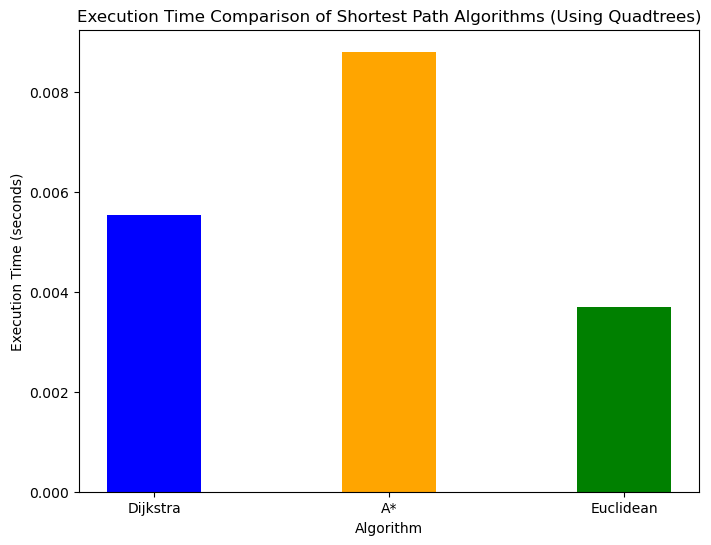

In [28]:
import time
def measure_dijkstra_execution_time(quadtree, target_lat, target_lon, type_mapping):
    start_time = time.time()
    nearest_responses_dijkstra, distances_dijkstra = dijkstra_quadtree(quadtree, target_lat, target_lon, type_mapping)
    return time.time() - start_time

def measure_a_star_execution_time(quadtree, target_lat, target_lon, type_mapping):
    start_time = time.time()
    nearest_responses_a_star, distances_a_star = a_star_quadtree(quadtree, target_lat, target_lon, type_mapping)
    return time.time() - start_time

def measure_eculidean_execution_time(quadtree, target_lat, target_lon, type_mapping):
    start_time = time.time()
    nearest_responses = find_nearest_responses_by_type(quadtree, target_lat, target_lon, type_mapping)
    return time.time() - start_time

target_latitude = 13.5
target_longitude = 77.5

dijkstra_time = measure_dijkstra_execution_time(quadtree, target_latitude, target_longitude, type_mapping)
a_star_time = measure_a_star_execution_time(quadtree, target_latitude, target_longitude, type_mapping)
euc_time = measure_eculidean_execution_time(quadtree, target_latitude, target_longitude, type_mapping)

algorithms = ['Dijkstra', 'A*', 'Euclidean']
execution_times = [dijkstra_time, a_star_time, euc_time]

plt.figure(figsize=(8, 6))
plt.bar(algorithms,  execution_times, width=0.4,color=['blue', 'orange', 'green'])
plt.title("Execution Time Comparison of Shortest Path Algorithms (Using Quadtrees)")
plt.xlabel("Algorithm")
plt.ylabel("Execution Time (seconds)")
plt.show()